# Estimation of effective connectivity using MOU process (MOU-EC)

This Python notebook estimates a matrix of MOU-EC for each fMRI session. The dataset comprises 22 subjects with 5 sessions each (2 for resting-state and 3 for movie, with distinct parts of the movie).

In [10]:
# install the pyMOU library using pip
! pip install git+https://github.com/MatthieuGilson/pyMOU.git@master

  Cloning https://github.com/MatthieuGilson/pyMOU.git (to revision master) to /tmp/pip-req-build-85kf4ifx
  Stored in directory: /tmp/pip-ephem-wheel-cache-sc2qc_vf/wheels/fd/ce/66/930772f3e93c5a7f47e74b3c14b9cd52862d2976cfd71de4f8
Successfully built pyMOU


In [4]:
import os
import numpy as np
import scipy.signal as spsg
import scipy.stats as stt
from pyMOU.MOU_model import MOU
import matplotlib.pyplot as plt

res_dir = '../model_param/'
if not os.path.exists(res_dir):
    print('create directory:',res_dir)
    os.makedirs(res_dir)


## Movie dataset

shape of data array: (22, 5, 66, 300)


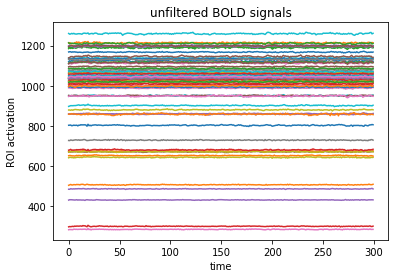

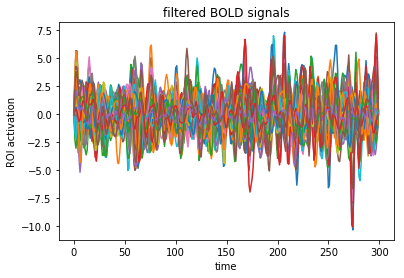

In [2]:
######################
# fMRI data properties    
n_sub = 22 # number of subjects
n_run = 5 # number of sessions/runs: 2 rest + 3 movie
N = 66 # number of ROIs
T = 300 # number of TRs for each session


#################
# functional data
ts_emp = np.load('../movie_data/ts_emp.npy')
print('shape of data array:', ts_emp.shape)

# filtering between 0.01 and 0.1 Hz
n_order = 3
Nyquist_freq = 0.5 / 2. # time resolution (TR) for fMRI = 2 seconds
low_f = 0.01 / Nyquist_freq
high_f = 0.1 / Nyquist_freq
b,a = spsg.iirfilter(n_order,[low_f,high_f],btype='bandpass',ftype='butter')

filtered_ts_emp = spsg.filtfilt(b,a,ts_emp, axis=-1)

# plots
plt.figure()
plt.plot(range(T),ts_emp[0,0,:,:].T)
plt.xlabel('time')
plt.ylabel('ROI activation')
plt.title('unfiltered BOLD signals')

plt.figure()
plt.plot(range(T),filtered_ts_emp[0,0,:,:].T)
plt.xlabel('time')
plt.ylabel('ROI activation')
plt.title('filtered BOLD signals')

plt.show()

In [5]:
# labels for brain regions (ROIs)
ROI_labels = np.load('../movie_data/ROI_labels.npy')
print('original order:\n', ROI_labels)

# reorder ROIs with inverse order for the two hemispheres
new_ind = np.zeros([N],dtype=np.int)
new_ind[:int(N/2)] = np.arange(int(N/2))
new_ind[int(N/2):] = N - 1 - np.arange(int(N/2))
#print(new_ind)

ROI_labels = ROI_labels[new_ind]
filtered_ts_emp = filtered_ts_emp[:,:,new_ind,:]
print('new order:\n', ROI_labels)



original order:
 ['rBSTS' ' rCAC' ' rCMF' ' rCUN' ' rENT' '  rFP' ' rFUS' '  rIP' '  rIT'
 'rISTC' 'rLOCC' ' rLOF' 'rLING' ' rMOF' '  rMT' 'rPARC' 'rPARH' 'rPOPE'
 'rPORB' 'rPTRI' 'rPCAL' 'rPSTC' '  rPC' 'rPREC' 'rPCUN' ' rRAC' ' rRMF'
 '  rSF' '  rSP' '  rST' 'rSMAR' '  rTP' '  rTT' 'lBSTS' ' lCAC' ' lCMF'
 ' lCUN' ' lENT' '  lFP' ' lFUS' '  lIP' '  lIT' 'lISTC' 'lLOCC' ' lLOF'
 'lLING' ' lMOF' '  lMT' 'lPARC' 'lPARH' 'lPOPE' 'lPORB' 'lPTRI' 'lPCAL'
 'lPSTC' '  lPC' 'lPREC' 'lPCUN' ' lRAC' ' lRMF' '  lSF' '  lSP' '  lST'
 'lSMAR' '  lTP' '  lTT']
new order:
 ['rBSTS' ' rCAC' ' rCMF' ' rCUN' ' rENT' '  rFP' ' rFUS' '  rIP' '  rIT'
 'rISTC' 'rLOCC' ' rLOF' 'rLING' ' rMOF' '  rMT' 'rPARC' 'rPARH' 'rPOPE'
 'rPORB' 'rPTRI' 'rPCAL' 'rPSTC' '  rPC' 'rPREC' 'rPCUN' ' rRAC' ' rRMF'
 '  rSF' '  rSP' '  rST' 'rSMAR' '  rTP' '  rTT' '  lTT' '  lTP' 'lSMAR'
 '  lST' '  lSP' '  lSF' ' lRMF' ' lRAC' 'lPCUN' 'lPREC' '  lPC' 'lPSTC'
 'lPCAL' 'lPTRI' 'lPORB' 'lPOPE' 'lPARH' 'lPARC' '  lMT' ' lMOF' 'lLI

## Functional connectivity

max FC value (most of the distribution should be between 0 and 1): 0.10476835339902636


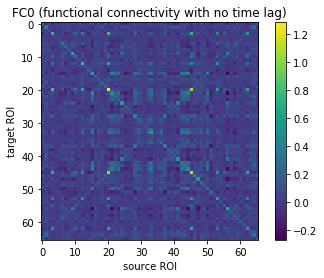

In [27]:
# time shifts for FC: 0, 1 and 2 TR
v_tau = np.arange(3,dtype=float)
n_tau = v_tau.size

FC_emp = np.zeros([n_sub,n_run,n_tau,N,N]) # FC = spatiotemporal covariances of BOLD signals
for i_sub in range(n_sub):
    for i_run in range(n_run):
        # center the time series
        filtered_ts_emp[i_sub,i_run,:,:] -= np.outer(filtered_ts_emp[i_sub,i_run,:,:].mean(1),np.ones([T]))
        # calculate covariances with time shift
        for i_tau in range(n_tau):
            FC_emp[i_sub,i_run,i_tau,:,:] = np.tensordot(filtered_ts_emp[i_sub,i_run,:,0:T-n_tau+1],filtered_ts_emp[i_sub,i_run,:,i_tau:T-n_tau+1+i_tau],axes=(1,1)) / float((T-n_tau))

rescale_FC_factor = 0.5 / FC_emp[:,:2,0,:,:].diagonal(axis1=2,axis2=3).mean()
FC_emp *= rescale_FC_factor
filtered_ts_emp /= np.sqrt(rescale_FC_factor)

print('max FC value (most of the distribution should be between 0 and 1):',FC_emp.mean())

# show FC0 for first subject, first run (rest)
plt.figure()
plt.imshow(FC_emp[0,0,0,:,:])
plt.colorbar()
plt.xlabel('source ROI')
plt.ylabel('target ROI')
plt.title('FC0 (functional connectivity with no time lag)')

plt.show()

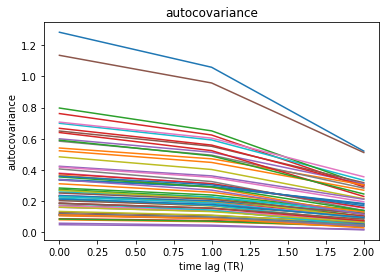

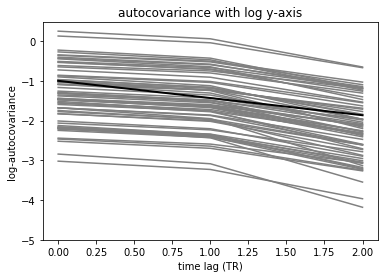

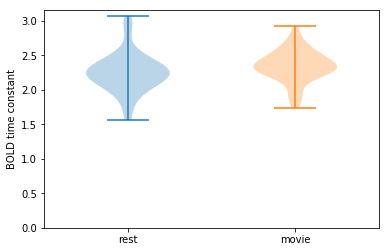

In [28]:
# calculate the autocorrelation for each ROI
ac = FC_emp.diagonal(axis1=3,axis2=4)

# calculate the time constant for the exponential decay for each subject and run (average over all ROIs)
tau_BOLD = np.zeros([n_sub,n_run])
for i_sub in range(n_sub):
    for i_run in range(n_run):
        slope_coef = np.polyfit(range(n_tau), np.log(np.maximum(ac[i_sub,i_run],1e-5)).mean(-1), 1)
        tau_BOLD[i_sub,i_run] = -1. / slope_coef[0]

# plots
plt.figure()
plt.plot(np.arange(n_tau), ac[0,0,:,:])
plt.xlabel('time lag (TR)')
plt.ylabel('autocovariance')
plt.title('autocovariance')

plt.figure()
plt.plot(np.arange(n_tau), np.log(np.maximum(ac[0,0],1e-5)), c=[0.5,0.5,0.5])
plt.plot(np.arange(n_tau), -1-np.arange(n_tau)/tau_BOLD[0,0], c='k', lw=2)
plt.axis(ymin=-5)
plt.xlabel('time lag (TR)')
plt.ylabel('log-autocovariance')
plt.title('autocovariance with log y-axis')

plt.figure()
plt.violinplot(tau_BOLD[:,:2].flatten(), positions=[0]) # time constants for rest
plt.violinplot(tau_BOLD[:,2:].flatten(), positions=[1]) # time constants for movie
plt.axis(xmin=-0.5, xmax=1.5, ymin=0)
plt.xticks([0,1], ['rest','movie'])
plt.ylabel('BOLD time constant')

plt.show()

## Structural connectivity for movie data

EC density: 0.27505827505827507


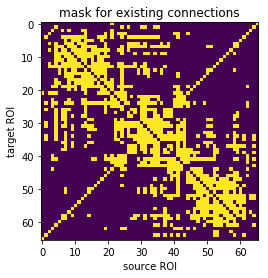

In [38]:
SC_anat = np.load('../movie_data/SC_anat.npy')

lim_SC = 0. # limit DTI value to determine SC (only connections with larger values are tuned)

# mask for existing connections for EC
mask_EC = np.zeros([N,N],dtype=bool) # EC weights to tune
mask_EC[SC_anat>lim_SC] = True
for i in range(N):
    mask_EC[i,i] = False # no self connection
    mask_EC[i,N-1-i] = True # additional interhemispheric connections
print('EC density:',mask_EC.sum()/float(N*(N-1)))

# diagonal mask for input noise matrix (here, no input cross-correlation)
mask_Sigma = np.eye(N,dtype=bool)

# plots
plt.figure()
plt.imshow(SC_anat)
plt.xlabel('source ROI')
plt.ylabel('target ROI')
plt.title('stuctural connectivity (DTI data)')

plt.figure()
plt.imshow(mask_EC)
plt.xlabel('source ROI')
plt.ylabel('target ROI')
plt.title('mask for existing connections')

plt.show()

## MOU-EC estimation

In [16]:
####################
# model optimization
J_mod = np.zeros([n_sub,n_run,N,N]) # Jacobian (off-diagonal elements = EC)
Sigma_mod = np.zeros([n_sub,n_run,N,N]) # local variance
dist_mod = np.zeros([n_sub,n_run]) # model error
R2_mod = np.zeros([n_sub,n_run]) # model error

mou_model = MOU()

for i_sub in range(n_sub):
    for i_run in range(n_run):
        print('sub',i_sub,'; run',i_run)

        # estimate model parameters for each session
        mou_model.fit(filtered_ts_emp[i_sub,i_run,:,:].T,mask_C=mask_EC,mask_Sigma=mask_Sigma)

        J_mod[i_sub,i_run,:,:] = mou_model.J
        Sigma_mod[i_sub,i_run,:,:] = mou_model.Sigma
        dist_mod[i_sub,i_run] = mou_model.d_fit['distance']
        R2_mod[i_sub,i_run] = mou_model.d_fit['correlation']**2

# save results
np.save(res_dir+'FC_emp.npy',FC_emp) # empirical spatiotemporal FC
np.save(res_dir+'mask_EC.npy',mask_EC) # mask of optimized connections
np.save(res_dir+'mask_Sigma.npy',mask_Sigma) # mask of optimized Sigma elements

np.save(res_dir+'J_mod.npy',J_mod) # estimated Jacobian matrices (EC + inverse time constant on diagonal)
np.save(res_dir+'Sigma_mod.npy',Sigma_mod) # estimated Sigma matrices
np.save(res_dir+'dist_mod.npy',dist_mod) # model error

sub 0 ; run 0
sub 0 ; run 1
sub 0 ; run 2
sub 0 ; run 3
sub 0 ; run 4
sub 1 ; run 0
sub 1 ; run 1
sub 1 ; run 2
sub 1 ; run 3
sub 1 ; run 4
sub 2 ; run 0
sub 2 ; run 1
sub 2 ; run 2
sub 2 ; run 3
sub 2 ; run 4
sub 3 ; run 0
sub 3 ; run 1
sub 3 ; run 2
sub 3 ; run 3
sub 3 ; run 4
sub 4 ; run 0
sub 4 ; run 1
sub 4 ; run 2
sub 4 ; run 3
sub 4 ; run 4
sub 5 ; run 0
sub 5 ; run 1
sub 5 ; run 2
sub 5 ; run 3
sub 5 ; run 4
sub 6 ; run 0
sub 6 ; run 1
sub 6 ; run 2
sub 6 ; run 3
sub 6 ; run 4
sub 7 ; run 0
sub 7 ; run 1
sub 7 ; run 2
sub 7 ; run 3
sub 7 ; run 4
sub 8 ; run 0
sub 8 ; run 1
sub 8 ; run 2
sub 8 ; run 3
sub 8 ; run 4
sub 9 ; run 0
sub 9 ; run 1
sub 9 ; run 2
sub 9 ; run 3
sub 9 ; run 4
sub 10 ; run 0
sub 10 ; run 1
sub 10 ; run 2
sub 10 ; run 3
sub 10 ; run 4
sub 11 ; run 0
sub 11 ; run 1
sub 11 ; run 2
sub 11 ; run 3
sub 11 ; run 4
sub 12 ; run 0
sub 12 ; run 1
sub 12 ; run 2
sub 12 ; run 3
sub 12 ; run 4
sub 13 ; run 0
sub 13 ; run 1
sub 13 ; run 2
sub 13 ; run 3
sub 13 ; run 4


In [17]:
# display an exmaple MOU-EC matrix and the model error for all runs and subjects
plt.figure()
plt.imshow(np.maximum(J_mod[0,0,:,:],0))
plt.xlabel('source ROI')
plt.ylabel('target ROI')
plt.title('MOU-EC')

plt.figure()
plt.violinplot(dist_mod,positions=range(n_run))
plt.axis(ymin=0,ymax=1)
plt.xlabel('fMRI sessions')
plt.ylabel('model error')

plt.show()

## Exercises

- Compare graph metrics on EC (as a directed weighted matrix) to corresponding graph metrics for SC
- Compare EC between rest and movie

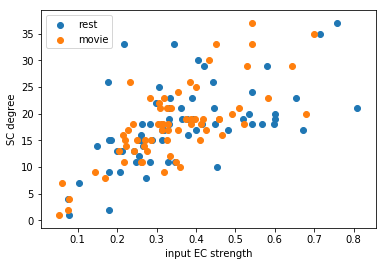

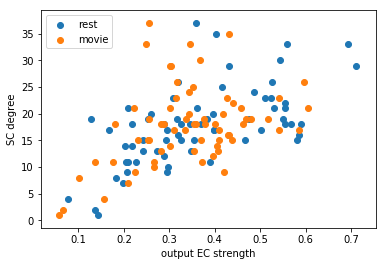

In [61]:
# compare EC and SC for a single subject
EC = np.copy(J_mod)
EC[:,:,np.eye(N,dtype=np.bool)] = 0

plt.figure()
plt.scatter(EC[0,0,:,:], SC_anat)
plt.xlabel('EC weight')
plt.ylabel('SC weight')
plt.title(stt.pearsonr(EC[0,0,mask_EC], SC_anat[mask_EC]))

plt.figure()
for i_sub in [0]: #range(n_sub):
    for i_run in [0,2]: #range(n_run):
        plt.scatter(EC[i_sub,i_run,:,:].sum(1), mask_EC.sum(1))
plt.legend(['rest','movie'])
plt.xlabel('input EC strength')
plt.ylabel('SC degree')

plt.figure()
for i_sub in [0]: #range(n_sub):
    for i_run in [0,2]: #range(n_run):
        plt.scatter(EC[i_sub,i_run,:,:].sum(0), mask_EC.sum(0))
plt.legend(['rest','movie'])
plt.xlabel('output EC strength')
plt.ylabel('SC degree')

plt.show()

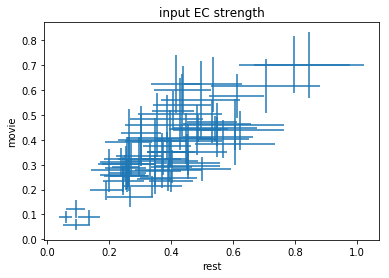

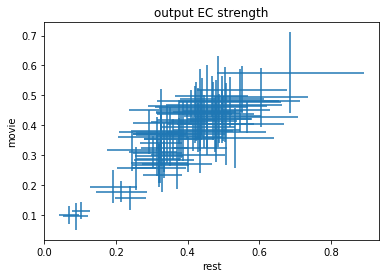

In [59]:
# compare EC between rest and movie
mean_inEC_rest = EC[:,:2,:,:].sum(3).mean(1) # input EC strength for rest
mean_inEC_movie = EC[:,2:,:,:].sum(3).mean(1) # input EC strength for movie
mean_outEC_rest = EC[:,:2,:,:].sum(2).mean(1) # output EC strength for rest
mean_outEC_movie = EC[:,2:,:,:].sum(2).mean(1) # output EC strength for movie


plt.figure()
plt.errorbar(mean_inEC_rest.mean(0), mean_inEC_movie.mean(0), xerr=mean_inEC_rest.std(0), yerr=mean_inEC_movie.std(0), ls='')
plt.xlabel('rest')
plt.ylabel('movie')
plt.title('input EC strength')

plt.figure()
plt.errorbar(mean_outEC_rest.mean(0), mean_outEC_movie.mean(0), xerr=mean_outEC_rest.std(0), yerr=mean_outEC_movie.std(0), ls='')
plt.xlabel('rest')
plt.ylabel('movie')
plt.title('output EC strength')

plt.show()

In [35]:
# statistical testing with Welch t-test for each EC weight between rest and movie

if True:
    # no correction
    threshold_EC = 0.01
else:
    # Bonferroni correction
    threshold_EC = 0.01 / mask_EC.sum()

sig_cnt = 0
for i in range(N):
    for j in range(N):
        if mask_EC[i,j]:
            t, pval = stt.ttest_ind(J_mod[:,:2,i,j].flatten(), J_mod[:,2:,i,j].flatten())
            if pval<threshold_EC:
                print('significant change in EC from', ROI_labels[j], 'to', ROI_labels[i])
                sig_cnt += 1
print(sig_cnt, 'significant changes')

significant change in EC from lBSTS to rBSTS
significant change in EC from  rRMF to  rCAC
significant change in EC from rSMAR to  rCAC
significant change in EC from lSMAR to  rCAC
significant change in EC from  lCAC to  rCAC
significant change in EC from   rIT to  rCMF
significant change in EC from  rMOF to  rCMF
significant change in EC from  lRAC to  rCUN
significant change in EC from lPCUN to  rCUN
significant change in EC from  lCUN to  rCUN
significant change in EC from   rIT to  rENT
significant change in EC from  lENT to  rENT
significant change in EC from rISTC to   rFP
significant change in EC from rLOCC to   rFP
significant change in EC from rPORB to   rFP
significant change in EC from   lFP to   rFP
significant change in EC from  rCMF to  rFUS
significant change in EC from rLING to  rFUS
significant change in EC from   rSP to  rFUS
significant change in EC from   lST to  rFUS
significant change in EC from   lIP to  rFUS
significant change in EC from  lFUS to  rFUS
significan

significant change in EC from   lIP to   lSF
significant change in EC from  lFUS to   lSF
significant change in EC from   rSF to  lRMF
significant change in EC from lSMAR to  lRMF
significant change in EC from   lSF to  lRMF
significant change in EC from lPCUN to  lRMF
significant change in EC from  lENT to  lRMF
significant change in EC from  lCAC to  lRMF
significant change in EC from   lTP to  lRAC
significant change in EC from lSMAR to  lRAC
significant change in EC from   rST to lPCUN
significant change in EC from  lRMF to lPCUN
significant change in EC from  lMOF to lPCUN
significant change in EC from  lCAC to lPCUN
significant change in EC from   lTT to lPREC
significant change in EC from   lTP to lPREC
significant change in EC from  lCUN to lPREC
significant change in EC from rPREC to   lPC
significant change in EC from   rST to   lPC
significant change in EC from rSMAR to   lPC
significant change in EC from   rTT to   lPC
significant change in EC from   lTT to   lPC
significan

In [36]:
# same between two rest sessions

sig_cnt = 0
for i in range(N):
    for j in range(N):
        if mask_EC[i,j]:
            t, pval = stt.ttest_ind(J_mod[:,0,i,j], J_mod[:,1,i,j])
            if pval<threshold_EC:
                print('significant change in EC from', ROI_labels[j], 'to', ROI_labels[i])
                sig_cnt += 1
print(sig_cnt, 'significant changes')

significant change in EC from rPARH to rLING
significant change in EC from  lFUS to lISTC
2 significant changes


In [54]:
# statistical testing with Welch t-test for each ROI in input EC strength between rest and movie

if True:
    # no correction
    threshold_N = 0.01
else:
    # Bonferroni correction
    threshold_N = 0.01 / N

sig_cnt = 0
for i in range(N):
    t, pval = stt.ttest_ind(J_mod[:,:2,i,:].sum(2).flatten(), J_mod[:,2:,i,:].sum(2).flatten())
    if pval<threshold_N:
        print('significant change in input EC strength of', ROI_labels[i])
        sig_cnt += 1
print(sig_cnt, 'significant changes')

significant change in input EC strength of rBSTS
significant change in input EC strength of  rCAC
significant change in input EC strength of  rENT
significant change in input EC strength of   rFP
significant change in input EC strength of  rFUS
significant change in input EC strength of   rIP
significant change in input EC strength of   rIT
significant change in input EC strength of rLOCC
significant change in input EC strength of  rLOF
significant change in input EC strength of   rMT
significant change in input EC strength of rPARC
significant change in input EC strength of rPARH
significant change in input EC strength of rPOPE
significant change in input EC strength of rPORB
significant change in input EC strength of rPTRI
significant change in input EC strength of   rPC
significant change in input EC strength of   rST
significant change in input EC strength of rSMAR
significant change in input EC strength of   rTP
significant change in input EC strength of   rTT
significant change i

In [55]:
# statistical testing with Welch t-test for each ROI in output EC strength between rest and movie

sig_cnt = 0
for i in range(N):
    t, pval = stt.ttest_ind(J_mod[:,:2,:,i].sum(2).flatten(), J_mod[:,2:,:,i].sum(2).flatten())
    if pval<threshold_N:
        print('significant change in output EC strength of', ROI_labels[i])
        sig_cnt += 1
print(sig_cnt, 'significant changes')

significant change in output EC strength of rBSTS
significant change in output EC strength of  rCAC
significant change in output EC strength of   rFP
significant change in output EC strength of rISTC
significant change in output EC strength of rLOCC
significant change in output EC strength of rLING
significant change in output EC strength of rPOPE
significant change in output EC strength of rPORB
significant change in output EC strength of   rPC
significant change in output EC strength of  rRMF
significant change in output EC strength of   rTT
significant change in output EC strength of lSMAR
significant change in output EC strength of   lST
significant change in output EC strength of   lSF
significant change in output EC strength of lPREC
significant change in output EC strength of   lPC
significant change in output EC strength of lPORB
significant change in output EC strength of   lMT
significant change in output EC strength of   lFP
significant change in output EC strength of  lENT
